Installing and Importing the required modules and classes from torch, torchvision, numpy, and matplotlib.

In [1]:
import os
import torch
import  torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import STL10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1 - Exploring the STL10 dataset

We  download the data and create a PyTorch dataset using the STL10 class from torchvision.datasets.

**STL-10 dataset**

The STL-10 dataset is an image recognition dataset for developing unsupervised feature learning, deep learning, self-taught learning algorithms. It is inspired by the CIFAR-10 dataset but with some modifications. In particular, each class has fewer labeled training examples than in CIFAR-10, but a very large set of unlabeled examples is provided to learn image models prior to supervised training. The primary challenge is to make use of the unlabeled data (which comes from a similar but different distribution from the labeled data) to build a useful prior. We also expect that the higher resolution of this dataset (96x96) will make it a challenging benchmark for developing more scalable unsupervised learning methods.

**Overview**
- 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
- Images are 96x96 pixels, color.
- 500 training images (10 pre-defined folds), 800 test images per class.
- 100000 unlabeled images for unsupervised learning. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.

In [4]:
# path to store/load data
dataset = STL10(root='/content/drive/MyDrive/data', download=True, transform=ToTensor())
test_dataset = STL10(root='/content/drive/MyDrive/data', split ='test', transform=ToTensor())


  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/data/stl10_binary.tar.gz to /content/drive/MyDrive/data


**The No of images in the training and testing dataset** 
**List the no of  output classes in the dataset**


In [5]:
dataset_size = len(dataset)
train_ds = dataset
test_dataset_size = len(test_dataset)
classes = dataset.classes
dataset_size,train_ds.data.shape,test_dataset_size,dataset.classes,len(dataset.classes)

(5000,
 (5000, 3, 96, 96),
 8000,
 ['airplane',
  'bird',
  'car',
  'cat',
  'deer',
  'dog',
  'horse',
  'monkey',
  'ship',
  'truck'],
 10)

**The shape of an image tensor from the dataset**

In [6]:
img, label = train_ds[0]
img_shape = img.shape
img_shape

torch.Size([3, 96, 96])

Note that this dataset consists of 3-channel color images (RGB). Let us look at a sample image from the dataset. `matplotlib` expects channels to be the last dimension of the image tensors (whereas in PyTorch they are the first dimension), so we'll the `.permute` tensor method to shift channels to the last dimension. Let's also print the label for the image.

Visualize the data using the Matplotlib package. Plot 4 different examples from each class in a grid of 10 × 4 (i.e., 10 rows, each contains 4 different examples from the same class). Label each row with the class name:


Label (numeric): 1

Label (textual): bird


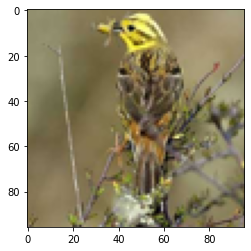

In [7]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

**The number of images belonging to each class**

In [8]:
count_class = {}
for _,outs in dataset: 
    labels = classes[outs]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1 
count_class 

{'bird': 500,
 'dog': 500,
 'horse': 500,
 'cat': 500,
 'truck': 500,
 'monkey': 500,
 'deer': 500,
 'ship': 500,
 'airplane': 500,
 'car': 500}

##### Preparing the data for training

We'll use a validation set with 1500 images . To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [9]:
torch.manual_seed(43)
val_size = 1500
test_size = len(test_dataset) - val_size

Let's use the `random_split` method to create the training & validation sets

In [10]:
test_ds, val_ds = random_split(test_dataset, [test_size, val_size])
len(test_ds), len(val_ds)

(6500, 1500)

We can now create data loaders to load the data in batches.

In [11]:
batch_size=128

In [12]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


Let's visualize a batch of data using the `make_grid` helper function from Torchvision.

images.shape: torch.Size([128, 3, 96, 96])


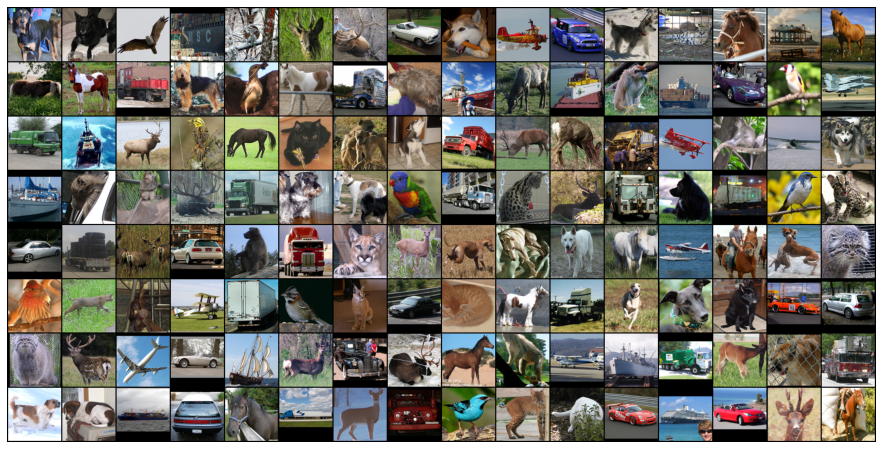

In [13]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break


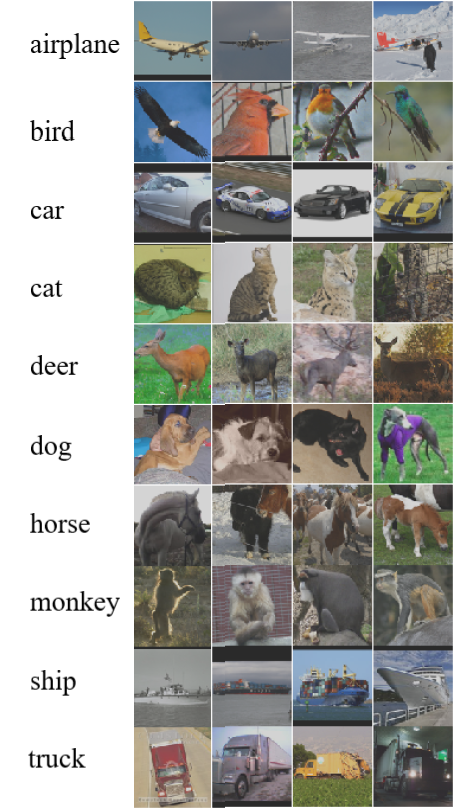

## Base Model class & Training on GPU

Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the `__init__` and `__forward__` methods. We will later extend this class to try out different architectures. 

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

The exact same training loop as before. 

In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Move  data & labels to the GPU, if one is available.

In [17]:
torch.cuda.is_available()

True

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Helper functions for plotting the losses & accuracies.

In [21]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [53]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(list(reversed(accuracies)), '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

Let's move our data loaders to the appropriate device.

In [23]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Part 2 - Training the model

We will make several attempts at training the model. Each time, try a different architecture and a different set of learning rates. Here are some ideas to try:
- Increase or decrease the number of hidden layers
- Increase of decrease the size of each hidden layer
- Try different activation functions
- Try training for different number of epochs
- Try different learning rates in every epoch


**Implement the following networks:**

1. Logistic regression over flattened version of the images
2. Fully-connected NN with at least 3 hidden layers over flattened version of the images followed by a classification layer. Apply batch normalization and dropout to all hidden layers.
3. CNN with at least two convolution layers and two pooling layers followed by two fully connected layers and a classification layer. Apply batch normalization to the convolution layers and dropout to the fully connected layers.
4. A fixed pre-trained MobileNetV2 as feature extractor followed by two fully connected layers and an additional classification layer. To clarify, you need to learn only the parameters of the task head.
5. A learned pre-trained MobileNetV2 as feature extractor followed by two fully connected layers and an additional classification layer. Here, you need to learn the parameters of the MobileNetV2 as well.


In [24]:
input_size = 3*96*96
output_size = 10

### Logistic regression over flattened version of the images




In [25]:
class STL10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.quasi_Linear = nn.Sequential(
            # Hidden layer 1
            nn.Linear(input_size,1024),
            # Activation fuction 1
            nn.PReLU(),
            # Hidden layer 2
            nn.Linear(1024,256),
            # Activation fuction 2
            nn.PReLU(),
            # Hidden layer 3
            nn.Linear(256,64),
            # Activation fuction 3
            nn.PReLU(),
            nn.Linear(64,output_size)
        )
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.quasi_Linear(out)
        return out

We now instantiate the model, and move it the appropriate device.

In [26]:
model = to_device(STL10Model(), device)

Before wetrain the model, it's a good idea to check the validation loss & accuracy with the initial set of weights.

In [27]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3014421463012695, 'val_acc': 0.10727982968091965}]

**We Train the model using the `fit` function to reduce the validation loss & improve accuracy.**



In [28]:
epochs,lr =(5,1e-1)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.1 ...

Epoch [0], val_loss: 2.1990, val_acc: 0.1546

Epoch [1], val_loss: 2.2661, val_acc: 0.1717

Epoch [2], val_loss: 2.0834, val_acc: 0.2060

Epoch [3], val_loss: 2.1385, val_acc: 0.2019

Epoch [4], val_loss: 2.0155, val_acc: 0.2743


In [29]:
epochs,lr =(5,5e-2)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.05 ...

Epoch [0], val_loss: 1.8822, val_acc: 0.2922

Epoch [1], val_loss: 1.9532, val_acc: 0.2654

Epoch [2], val_loss: 2.0582, val_acc: 0.2611

Epoch [3], val_loss: 2.3622, val_acc: 0.2038

Epoch [4], val_loss: 2.0523, val_acc: 0.2656


In [30]:
epochs,lr =(5,2e-2)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.02 ...

Epoch [0], val_loss: 1.8371, val_acc: 0.2858

Epoch [1], val_loss: 1.8635, val_acc: 0.2947

Epoch [2], val_loss: 2.1892, val_acc: 0.2448

Epoch [3], val_loss: 1.9964, val_acc: 0.2975

Epoch [4], val_loss: 1.7401, val_acc: 0.3572


In [31]:
epochs,lr =(5,1e-2)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.01 ...

Epoch [0], val_loss: 1.7550, val_acc: 0.3493

Epoch [1], val_loss: 1.7901, val_acc: 0.3366

Epoch [2], val_loss: 1.7469, val_acc: 0.3586

Epoch [3], val_loss: 1.8157, val_acc: 0.3255

Epoch [4], val_loss: 1.6967, val_acc: 0.3672


In [32]:
epochs,lr =(5,5e-3)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.005 ...

Epoch [0], val_loss: 1.7098, val_acc: 0.3554

Epoch [1], val_loss: 1.6663, val_acc: 0.3846

Epoch [2], val_loss: 1.6713, val_acc: 0.3980

Epoch [3], val_loss: 1.6817, val_acc: 0.3822

Epoch [4], val_loss: 1.7109, val_acc: 0.3701


In [33]:
epochs,lr =(5,2e-3)
#  in tranin_hyper_para :
print(f" training for {epochs} epochs , with a learning rate of {lr} ...")
history += fit(epochs, lr, model, train_loader, val_loader)

 training for 5 epochs , with a learning rate of 0.002 ...

Epoch [0], val_loss: 1.6638, val_acc: 0.3967

Epoch [1], val_loss: 1.6590, val_acc: 0.3836

Epoch [2], val_loss: 1.6592, val_acc: 0.3839

Epoch [3], val_loss: 1.6615, val_acc: 0.3966

Epoch [4], val_loss: 1.6578, val_acc: 0.3921


Plot the losses and the accuracies to check if we're starting to hit the limits of how well our model can perform on this dataset. we can train some more if we can see the scope for further improvement.

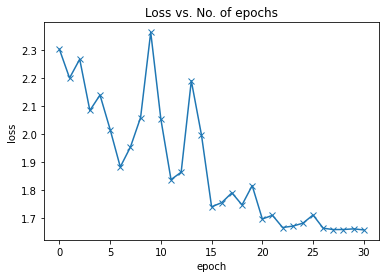

In [34]:
plot_losses(history)

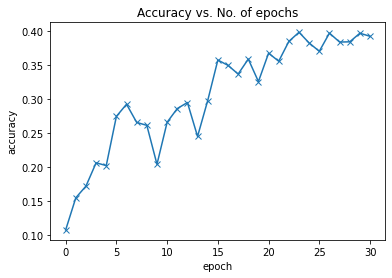

In [35]:
plot_accuracies(history)

Finally, evaluate the model on the test dataset report its final performance.

In [36]:
evaluate(model, test_loader)

{'val_loss': 1.6538206338882446, 'val_acc': 0.390869140625}

## Recoding our results

As our perform multiple experiments, it's important to record the results in a systematic fashion, so that we can review them later and identify the best approaches that wemight want to reproduce or build upon later. 



In [37]:
arch = "3 layers (1024,256,64) "
lrs = [1e-1,5e-2,2e-2,1e-2,5e-3,2e-3]
epochs = [5,5,5,5,5,5]

**The final test accuracy & test loss**

In [38]:
test_acc = history
test_loss = history
test_acc,test_loss

([{'val_loss': 2.3014421463012695, 'val_acc': 0.10727982968091965},
  {'val_loss': 2.199021816253662, 'val_acc': 0.15455728769302368},
  {'val_loss': 2.266101837158203, 'val_acc': 0.17170928418636322},
  {'val_loss': 2.083366870880127, 'val_acc': 0.20597775280475616},
  {'val_loss': 2.138481616973877, 'val_acc': 0.20192945003509521},
  {'val_loss': 2.015456438064575, 'val_acc': 0.2742897570133209},
  {'val_loss': 1.882187843322754, 'val_acc': 0.29217565059661865},
  {'val_loss': 1.953155755996704, 'val_acc': 0.26540008187294006},
  {'val_loss': 2.058206081390381, 'val_acc': 0.2610795497894287},
  {'val_loss': 2.362196922302246, 'val_acc': 0.20379972457885742},
  {'val_loss': 2.0522594451904297, 'val_acc': 0.2656368315219879},
  {'val_loss': 1.837109088897705, 'val_acc': 0.2857836186885834},
  {'val_loss': 1.8634766340255737, 'val_acc': 0.29468512535095215},
  {'val_loss': 2.1891884803771973, 'val_acc': 0.2447798252105713},
  {'val_loss': 1.9964393377304077, 'val_acc': 0.297502368688583

The highest validation accuracy we can get was 39% with feed forward neural network

### Convolutional Neural Networks in PyTorch


Defining the Model (Convolutional Neural Network)

We will use a convolutional neural network, using the `nn.Conv2d` class from PyTorch..

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a max-pooling layers to progressively decrease the height & width of the output tensors from each convolutional layer.

We'll use `nn.Sequential` to chain the layers and activations functions into a single network architecture.

In [39]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': 1-acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [40]:
class Stl10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 48 x 48

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 24 x 24

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 12 x 12
            nn.Conv2d(256,512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 6 x 6
            nn.Flatten(), 
            nn.Linear(512*6*6, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [41]:
model = Stl10CnnModel()
model

Stl10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. These are described in more detail in the [previous tutorial](https://jovian.ml/aakashns/04-feedforward-nn#C21).

In [42]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where we're running this notebook, our default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [43]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [44]:
val_dl = val_loader
train_dl = train_loader
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [45]:
## Training the Model

#We can use the exact same `fit` and `evaluate` functions as defined in the previous tutorials.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [46]:
model = to_device(Stl10CnnModel(), device)

In [47]:
evaluate(model, val_dl)

{'val_loss': 2.302485227584839, 'val_acc': 0.9013967514038086}

The initial accuracy is around 90%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).
We'll use the following *hyperparmeters* (learning rate, no. of epochs, batch_size etc.) to train our model. As an exercise, we can try changing these to see if wehave achieve a higher accuracy in a shorter time. 


In [51]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
torch.cuda.empty_cache()

In [52]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], val_loss: 2.3024, val_acc: 0.9014

Epoch [1], val_loss: 2.3029, val_acc: 0.9063

Epoch [2], val_loss: 2.3107, val_acc: 0.8992

Epoch [3], val_loss: 2.2494, val_acc: 0.8084

Epoch [4], val_loss: 2.1645, val_acc: 0.7976

Epoch [5], val_loss: 1.8956, val_acc: 0.7368

Epoch [6], val_loss: 1.8191, val_acc: 0.7170

Epoch [7], val_loss: 1.9052, val_acc: 0.7029

Epoch [8], val_loss: 1.6494, val_acc: 0.6494

Epoch [9], val_loss: 1.5850, val_acc: 0.6146

Epoch [10], val_loss: 1.5577, val_acc: 0.6042

Epoch [11], val_loss: 1.6520, val_acc: 0.6362

Epoch [12], val_loss: 1.5598, val_acc: 0.5761

Epoch [13], val_loss: 1.4819, val_acc: 0.5549

Epoch [14], val_loss: 1.6193, val_acc: 0.5612

Epoch [15], val_loss: 1.6147, val_acc: 0.5626

Epoch [16], val_loss: 1.5183, val_acc: 0.5395

Epoch [17], val_loss: 1.5675, val_acc: 0.5395

Epoch [18], val_loss: 1.5890, val_acc: 0.5316

Epoch [19], val_loss: 1.8630, val_acc: 0.5239

Epoch [20], val_loss: 1.8649, val_acc: 0.5266

Epoch [21], val_loss: 2

We can also plot the valdation set accuracies to study how the model improves over time.

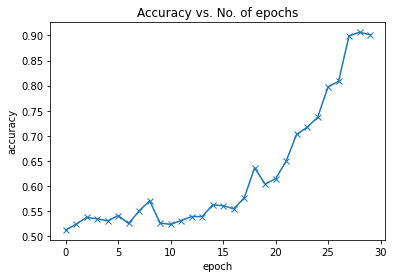

In [54]:
plot_accuracies(history)

Our model reaches an accuracy of around 90%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than 60% even after training for a long time. This suggests that we might need to use a more powerful model to capture the relationship between the images and the labels more accurately. This can be done by adding more convolutional layers to our model, or incrasing the no. of channels in each convolutional layer, or by using regularization techniques.

We can also plot the training and validation losses to study the trend.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

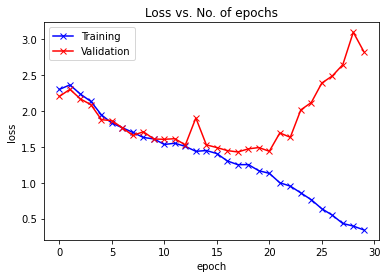

In [ ]:
plot_losses(history)

Initialy, both the training and validation losses seem to decrease over time. However, as we  train the model for 30 epochs, we notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after 12 epochs ! 

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by creating a test dataset using the `ImageFolder` class.

In [ ]:
test_dataset = test_ds

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

Label: bird , Predicted: bird


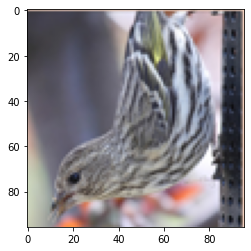

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: car , Predicted: truck


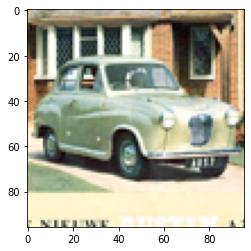

In [ ]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: airplane , Predicted: airplane


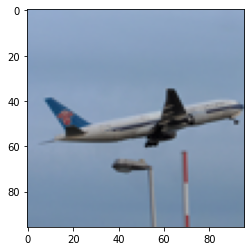

In [ ]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

As a final step, let's also look at the overall loss and accuracy of the model on the test set. We expect these values to be similar to those for the validation set. If not, we might need a better validation set that has similar data and distribution as the test set (which often comes from real world data).

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 2.7288930416107178, 'val_acc': 0.5319411158561707}

### Fully-connected NN with at least 3 hidden layers over flattened version of the images followed by a classification layer


We'll use the following techniques to train a state-of-the-art model in less than 5 minutes to achieve over 90% accuracy in  classifying images from the STL10 dataset:

- Data normalization
- Data augmentation
- Residual connections
- Batch normalization
- Learning rate scheduling
- Weight Decay
- Gradient clipping
- Adam optimizer

In [ ]:
# path to store/load data
dataset = STL10(root='/content/drive/MyDrive/data', download=True, transform=ToTensor())
test_dataset = STL10(root='/content/drive/MyDrive/data', split ='test', transform=ToTensor())
#dataset = STL10(root='data', download=True, transform=ToTensor())
#test_dataset = STL10(root='data', split ='test', transform=ToTensor())
dataset_size = len(dataset)
train_ds = dataset

Files already downloaded and verified


In [ ]:
torch.manual_seed(43)
val_size = 1500
test_size = len(test_dataset) - val_size
test_ds, valid_ds = random_split(test_dataset, [test_size, val_size])
len(test_ds), len(val_ds)

(6500, 1500)

We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once wehave picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)


image indices: [3392 2303 2325 2064]

torch.Size([3, 100, 394])


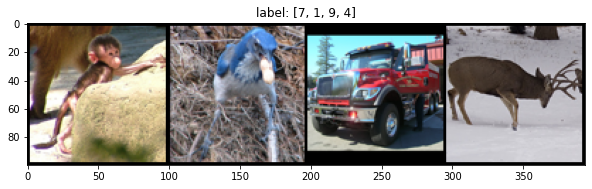

In [ ]:
from torchvision import utils
# fix random seed
np.random.seed(43)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [1344  255  277   58]

torch.Size([3, 100, 394])


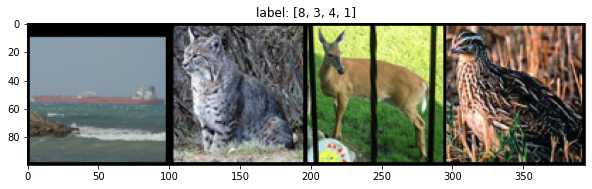

In [ ]:
np.random.seed(43)

grid_size=4
rnd_inds=np.random.randint(0,len(valid_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[valid_ds[i][0] for i in rnd_inds]
y_grid=[valid_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [ ]:
# RGB mean and std 
meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)

0.4467106 0.43980986 0.40664646

0.22414584 0.22148906 0.22389975


In [ ]:
# Data transforms (normalization & data augmentation)
import torchvision.transforms as tt
stats = ((meanR, meanG, meanB), (stdR, stdG, stdB))
train_tfms = tt.Compose([tt.RandomHorizontalFlip(p=0.5),
 tt.RandomVerticalFlip(p=0.5),           
 tt.ToTensor(), 
tt.Normalize(*stats,inplace=True)])                      

valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_ds.transform =  train_tfms
valid_ds.transform =  valid_tfms

Next, we can create data loaders for retrieving images in batches. We'll use a relatively large batch size of 500 to utlize a larger portion of the GPU RAM. we can try reducing the batch size & restarting the kernel if weface an "out of memory" error.


In [ ]:
batch_size = 300

In [ ]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


Let's take a look at some sample images from the training dataloader. To display the images, we'll need to _denormalize_ the pixels values to bring them back into the range `(0,1)`.

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

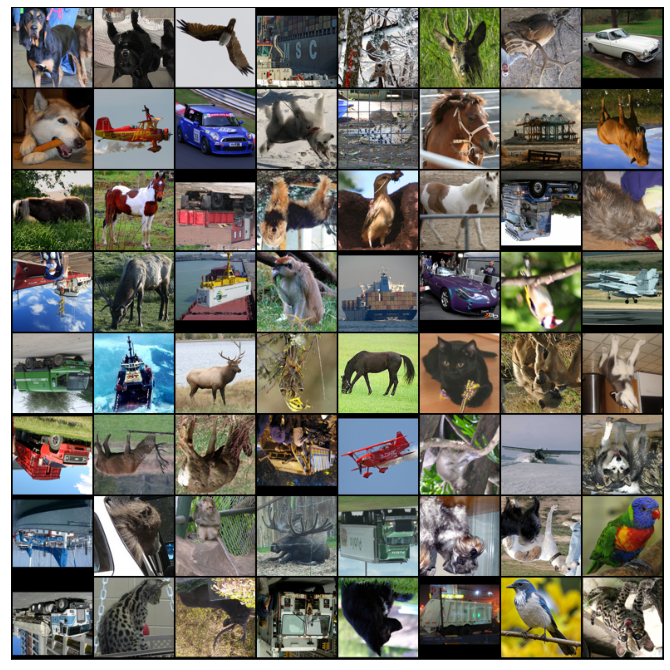

In [ ]:
show_batch(train_dl)

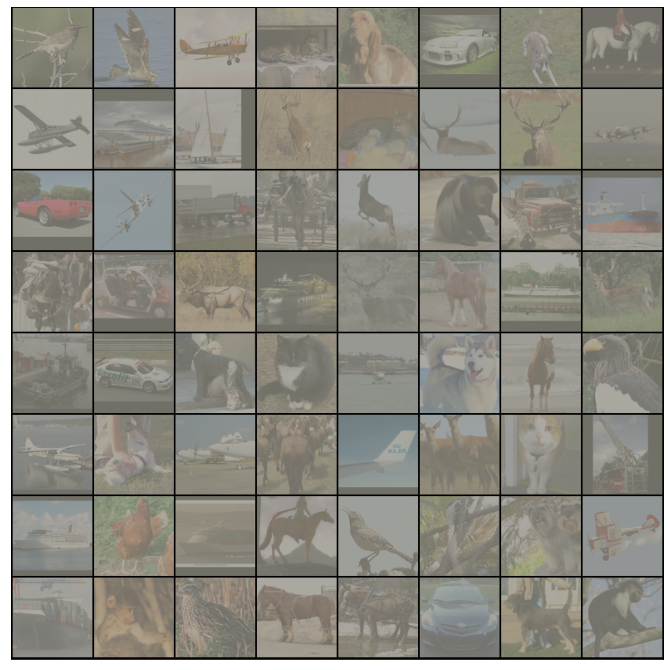

In [ ]:
show_batch(valid_dl)

The colors seem out of place because of the normalization. Note that normalization is also applied during inference. If we look closely, we can see the cropping and reflection padding in some of the images. Horizontal flip is a bit difficult to detect from visual inspection.

## Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. 

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where we're running this notebook, our default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

Here is a very simple Residual block:

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
simple_fullyConnectNN = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_fullyConnectNN(images)
    print(out.shape)
    break
    
del simple_fullyConnectNN, images, labels
torch.cuda.empty_cache()

torch.Size([300, 3, 96, 96])


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer. 



In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': 0.5+acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class FullyConnectedNN(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64,pool=True)
        self.conv2 = conv_block(64, 128, pool=True) # output: 128 x 24 x 24
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # output: 256 x 12 x 12
        self.conv4 = conv_block(256, 512, pool=True) # output: 512 x 6 x 6
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(FullyConnectedNN(3,10), device)
model

FullyConnectedNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(12

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. 

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. 

Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.302091121673584, 'val_acc': 0.5972222685813904}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. 

In [ ]:
epochs = 32
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00063, train_loss: 2.1883, val_loss: 4.5171, val_acc: 0.6050

Epoch [1], last_lr: 0.00135, train_loss: 1.6356, val_loss: 3.0006, val_acc: 0.7294

Epoch [2], last_lr: 0.00248, train_loss: 1.4817, val_loss: 5.1275, val_acc: 0.6094

Epoch [3], last_lr: 0.00391, train_loss: 1.3664, val_loss: 3.7467, val_acc: 0.6656

Epoch [4], last_lr: 0.00547, train_loss: 1.3222, val_loss: 2.8267, val_acc: 0.6822

Epoch [5], last_lr: 0.00700, train_loss: 1.3952, val_loss: 3.0779, val_acc: 0.6933

Epoch [6], last_lr: 0.00835, train_loss: 1.3675, val_loss: 2.7164, val_acc: 0.6417

Epoch [7], last_lr: 0.00935, train_loss: 1.5004, val_loss: 3.4323, val_acc: 0.5994

Epoch [8], last_lr: 0.00991, train_loss: 1.3278, val_loss: 3.0266, val_acc: 0.6956

Epoch [9], last_lr: 0.00999, train_loss: 1.4081, val_loss: 2.8860, val_acc: 0.6617

Epoch [10], last_lr: 0.00990, train_loss: 1.1571, val_loss: 3.1506, val_acc: 0.6878

Epoch [11], last_lr: 0.00972, train_loss: 1.0519, val_loss: 2.8450, val_acc

Our model trained to over 90% accuracy in under 5 minutes! Try playing around with the data augmentations, network architecture & hyperparameters to achive the following results:

1. 94% accuracy in under 10 minutes (easy)
2. 90% accuracy in under 2.5 minutes (intermediate)
3. 94% accuracy in under 5 minutes (hard)


Let's plot the valdation set accuracies to study how the model improves over time.


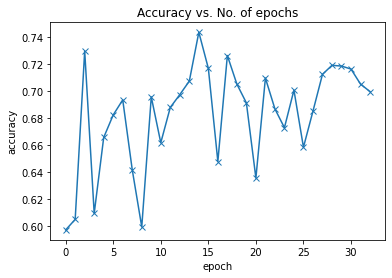

In [ ]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

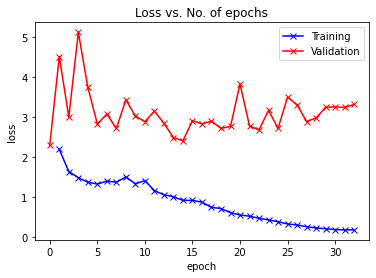

In [ ]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

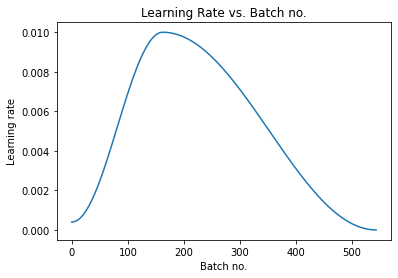

In [ ]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: bird , Predicted: bird


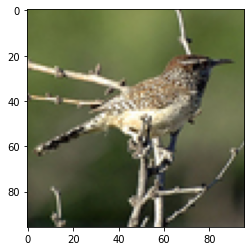

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: horse , Predicted: airplane


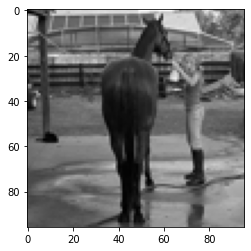

In [ ]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: ship , Predicted: ship


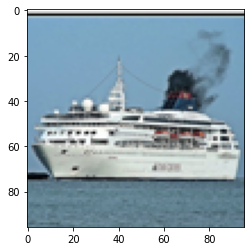

In [ ]:
img, label = valid_ds[1200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

### Fixed pre-trained MobileNetV2 as feature extractor followed by two fully connected layers and an additional classification layer.



In [ ]:
class fixedMobileNetV2(ImageClassificationBase):
    def __init__(self, input_size=32, num_class=1000):
        super().__init__()
        
        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, num_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
model = to_device(fixedMobileNetV2(3,10), device)
model

fixedMobileNetV2(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=

## Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our `fit` function:

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. 

* **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

* **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. 

Let's define a `fit_one_cycle` function to incorporate these changes. We'll also record the learning rate used for each batch.


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


[{'val_loss': 2.3037095069885254, 'val_acc': 0.5955555438995361}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. 

In [ ]:
epochs = 32
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00063, train_loss: 2.2230, val_loss: 2.5669, val_acc: 0.5972

Epoch [1], last_lr: 0.00135, train_loss: 1.9283, val_loss: 4.1367, val_acc: 0.5972

Epoch [2], last_lr: 0.00248, train_loss: 1.7416, val_loss: 6.6436, val_acc: 0.6222

Epoch [3], last_lr: 0.00391, train_loss: 1.7091, val_loss: 9.9389, val_acc: 0.6078

Epoch [4], last_lr: 0.00547, train_loss: 1.5832, val_loss: 3.3762, val_acc: 0.6228

Epoch [5], last_lr: 0.00700, train_loss: 1.5402, val_loss: 2.9133, val_acc: 0.6561

Epoch [6], last_lr: 0.00835, train_loss: 1.5207, val_loss: 2.5782, val_acc: 0.6450

Epoch [7], last_lr: 0.00935, train_loss: 1.4635, val_loss: 3.2269, val_acc: 0.6033

Epoch [8], last_lr: 0.00991, train_loss: 1.4605, val_loss: 3.1807, val_acc: 0.6139

Epoch [9], last_lr: 0.00999, train_loss: 1.3871, val_loss: 3.2212, val_acc: 0.5894

Epoch [10], last_lr: 0.00990, train_loss: 1.3513, val_loss: 3.1242, val_acc: 0.6161

Epoch [11], last_lr: 0.00972, train_loss: 1.2951, val_loss: 2.5735, val_acc

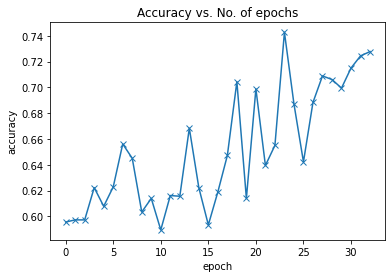

In [ ]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

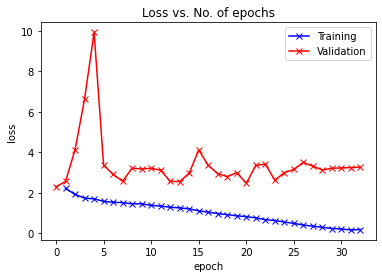

In [ ]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing batch normalization, data augmentation and residual layers one by one to study their effect on overfitting.

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

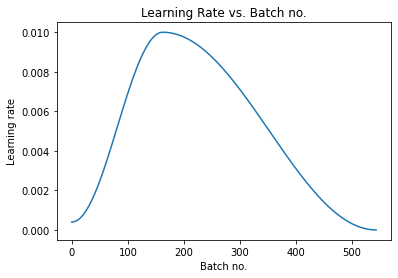

In [ ]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: bird , Predicted: bird


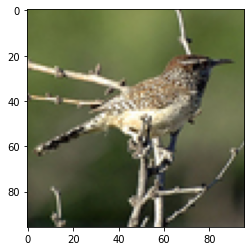

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: horse , Predicted: cat


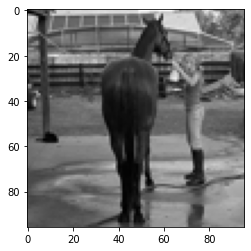

In [ ]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: ship , Predicted: ship


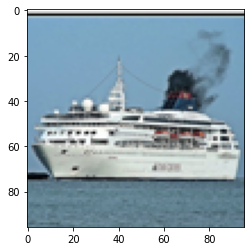

In [ ]:
img, label = valid_ds[1200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

### Learned pre-trained MobileNetV2 


In [ ]:
class MobileNetV2(ImageClassificationBase):
    def __init__(self, input_size=32, num_class=1000):
        super().__init__()
        
        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, num_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

def _mobilenet_v3_model(
    arch: str,
    last_channel: int,
    pretrained: bool,
    progress: bool,
):
    model = MobileNetV(inverted_residual_setting, last_channel, **kwargs)
    if pretrained:
        if model_urls.get(arch, None) is None:
            raise ValueError("No checkpoint is available for model type {}".format(arch))
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model

In [ ]:

model = to_device(MobileNetV2(3,10), device)
model

MobileNetV2(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(1, 1

## Training the model



In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3059396743774414, 'val_acc': 0.5955555438995361}]

We're now ready to train our model. Instead of SGD (stochastic gradient descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. 

In [ ]:
epochs = 32
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00063, train_loss: 2.0673, val_loss: 2.6627, val_acc: 0.5983

Epoch [1], last_lr: 0.00135, train_loss: 1.6713, val_loss: 3.3087, val_acc: 0.5878

Epoch [2], last_lr: 0.00248, train_loss: 1.5323, val_loss: 2.7573, val_acc: 0.6767

Epoch [3], last_lr: 0.00391, train_loss: 1.4796, val_loss: 3.5884, val_acc: 0.6067

Epoch [4], last_lr: 0.00547, train_loss: 1.4765, val_loss: 3.2777, val_acc: 0.6300

Epoch [5], last_lr: 0.00700, train_loss: 1.4417, val_loss: 2.4873, val_acc: 0.6522

Epoch [6], last_lr: 0.00835, train_loss: 1.3648, val_loss: 2.9106, val_acc: 0.6733

Epoch [7], last_lr: 0.00935, train_loss: 1.3226, val_loss: 2.5846, val_acc: 0.6744

Epoch [8], last_lr: 0.00991, train_loss: 1.1889, val_loss: 3.0717, val_acc: 0.5989

Epoch [9], last_lr: 0.00999, train_loss: 1.1720, val_loss: 2.6904, val_acc: 0.6222

Epoch [10], last_lr: 0.00990, train_loss: 1.1121, val_loss: 2.9686, val_acc: 0.6322

Epoch [11], last_lr: 0.00972, train_loss: 1.0018, val_loss: 3.4798, val_acc

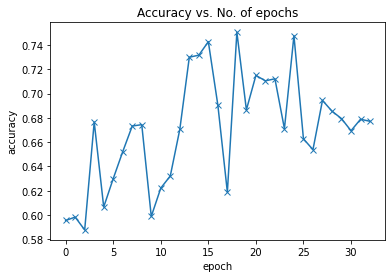

In [ ]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

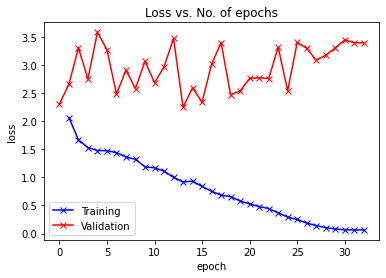

In [ ]:
plot_losses(history)

Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

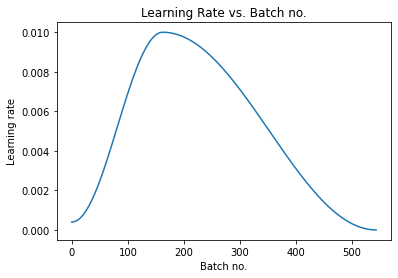

In [ ]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of `0.01`, and then gradually decreases to a very small value.

## Testing with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: bird , Predicted: bird


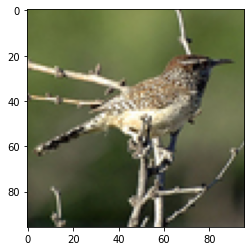

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: horse , Predicted: deer


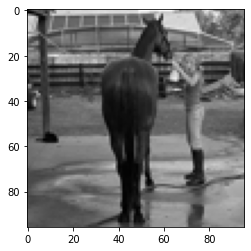

In [ ]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: ship , Predicted: ship


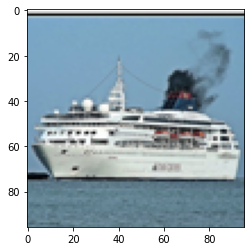

In [ ]:
img, label = valid_ds[1200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

# Summary of project for zero to GANS course on deep learning


* Introduction to the STL10 dataset for image classification
* Downloading, extracing and loading an image dataset using `torchvision`
* Show random batches of images in a grid using `torchvision.utils.make_grid`
* Creating a feedforward neural network 
* Training a feedforward neural network and visualizing the losses and errors 
## Maximun  accuracy of 38% obtained FFNN
* Creating a convolutional neural network using with `nn.Conv2d` and `nn.MaxPool2d` layers suitable for STL10 data set
* Training a convolutional neural network and visualizing the losses and errors.
## Maximum  accuracy of  50 % obtained with CNN
* Understanding overfitting and the strategies for avoiding it (more on this later)
* Generating predictions on single images from the test set


Next  we  continued to improve our model's accuracy using techniques like data augmentation, batch normalization and dropout. We modified the residual networks (or Fully-connected NN) to suit the STL10 dataset, a small but critical change to the model architecture that  significantly boost the performance of our model. 

We used the following techniques to improve the model performance and reduce the training time:

* **Data normalization**: We normalized the image tensors by subtracting the mean and dividing by the standard deviation of pixels across each channel. Normalizing the data prevents the pixel values from any one channel from disproportionately affecting the losses and gradients. 

* **Data augmentation**: We applied random transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability.

* **Residual connections**: One of the key changes to our CNN model was the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers. We used the Fully-connected NN architecture 

* **Batch normalization**: After each convolutional layer, we added a batch normalization layer, which normalizes the outputs of the previous layer. This is somewhat similar to data normalization, except it's applied to the outputs of a layer, and the mean and standard deviation are learned parameters. 

* **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. 

* **Weight Decay**: We added weight decay to the optimizer, yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function. 

* **Gradient clipping**: We also added gradient clippint, which helps limit the values of gradients to a small range to prevent undesirable changes in model parameters due to large gradient values during training.  

* **Adam optimizer**: Instead of SGD (stochastic gradient descent), we used the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. There are many other optimizers to choose froma and experiment with. 
